# Quantile Regressions

This notebook illustrates quantile regressions. 

## Loading Packages

In [1]:
using LinearAlgebra, Dates, DelimitedFiles, Statistics, MathProgBase, Ipopt

include("jlFiles/printmat.jl")
include("jlFiles/printTable.jl")

printblue(txt) = printstyled(string(txt,"\n"),color=:blue,bold=true)

printblue (generic function with 1 method)

In [2]:
using Plots

#pyplot(size=(600,400))            #pyplot() or gr()
gr(size=(480,320))
default(fmt = :svg)

## Loading Data

In [3]:
xx  = readdlm("Data/FFdFactors.csv",',',skipstart=1)
xx  = xx[:,2]            #equity market excess returns

y = xx[2:end]            #dependent variable
x = xx[1:end-1]          #regressor in an AR(1)

T   = size(y,1)
println("Sample size: $T")

Sample size: 15355


## A Function for Quantile Regressions

The next cell defines a function `QuantileRegressionPs` which estimates a quantile regression. 

The subsequent cells show the results.

In [4]:
"""
    QuantileRegressionPs(y,x,q=0.5)

Estimate a quantile regression, quantile q. The outputs are the point estimates 
and three different variance-covariance matrices of the estimates.

"""
function QuantileRegressionPs(y,x,q=0.5)

  (T,K) = (size(x,1),size(x,2))

  c   = vcat(fill(q,T),fill(1-q,T),zeros(K))        #c'[u;v;bet]
  A   = hcat(Matrix(1.0I,T,T),-Matrix(1.0I,T,T),x)  #u[t] - v[t] + x[t,:]*bet = y[t]
  b   = copy(vec(y))

  lb  = vcat(zeros(T),zeros(T),fill(-Inf,K))        #u>=0,v>=0
  ub  = fill(Inf,2*T+K)

  Sol = linprog(c,A,'=',b,lb,ub,IpoptSolver(print_level=1))

  if Sol.status == :Optimal
    theta = Sol.sol[2*T+1:end]          #extract regression coeffs
  else
    theta = NaN
  end

  res = y - x*theta

  D   = x'x/T
  h   = 1.06*std(res)/T^0.2                        #Silverman (1986) recommendation
  fx  = exp.(-0.5*((res/h).^2))./(h*sqrt(2*pi))    #Green 7th ed, using N() kernel
  f0  = mean(fx)
  C   = f0*x'x/T
  C_1 = inv(C)
  vcv = q*(1-q)*C_1*D*C_1/T                         #variance-covariance matrix

  C    = (fx.*x)'x/T                                #Wooldrige 2dn ed, Powell 1991
  C_1  = inv(C)                                     #but with Gaussian kernel
  vcv2 = q*(1-q)*C_1*D*C_1/T                        #caputures (x,res) dependence

  fx  = (abs.(res) .<= h/2)/h                       #Wooldrige 2nd ed, Powell 1991
  C   = (fx.*x)'x/T                                 #uniform kernel
  C_1 = inv(C)
  vcv3 = q*(1-q)*C_1*D*C_1/T

  return theta, vcv, vcv2, vcv3

end

QuantileRegressionPs

In [5]:
xGrid = quantile(x,0.01:0.01:0.99)                 #quantiles of the regressor, for plots
xGrid = [ones(size(xGrid)) xGrid]

qM = [0.01,0.05,0.25,0.5,0.75,0.95,0.99]           #quantiles

cx = [ones(T) x]                                   #[constant regressors]

bM    = fill(NaN,length(qM),2)                     #to store regression coeffs
qPred = fill(NaN,length(qM),size(xGrid,1))         #to store predicted values
for i = 1:length(qM)
    b_q        = QuantileRegressionPs(y,cx,qM[i])[1]
    bM[i,:]    = b_q
    qPred[i,:] = xGrid*b_q
end

printblue("quantile regression coefs:")
printTable([qM bM],["quantile","c","slope"],fill("",length(qM)))

println("\nThe function QuantileRegressionPs also outputs different variance-covariance matrices. Compare them.")


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

quantile regression coefs:
  quantile         c     slope
     0.010    -2.568     0.139
     0.050    -1.433     0.158
     0.250    -0.410     0.146
     0.500     0.047     0.067
     0.750     0.477     0.023
     0.950     1.409    -0.028
     0.990     2.582    -0.188


The function QuantileRegressionPs also outputs different variance-covariance matrices. Compare them.


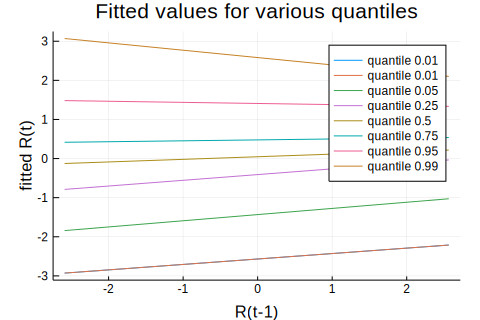

In [6]:
plot(xGrid[:,2], qPred[1,:],label="quantile $(qM[1])")
for i = 1:7
    plot!(xGrid[:,2],qPred[i,:],label="quantile $(qM[i])")
end    
xlabel!("R(t-1)")
ylabel!("fitted R(t)")
title!("Fitted values for various quantiles")